In [21]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
# from keras.layers import Dense, Input, GlobalMaxPooling1D
# from keras.layers import Conv1D, MaxPooling1D, Embedding
# from keras.models import Model
# from keras.initializers import Constant

In [29]:
def create_embedding_matrix(filepath, word_index, embedding_dim):
    vocab_size = len(word_index) + 1  # Adding again 1 because of reserved 0 index
    embedding_matrix = np.zeros((vocab_size, embedding_dim))

    with open(filepath, encoding='utf8') as f:
        for line in f:
            word, *vector = line.split()
            if word in word_index:
                idx = word_index[word]
                embedding_matrix[idx] = np.array(
                    vector, dtype=np.float32)[:embedding_dim]

    return embedding_matrix

In [11]:
# setting the data folder location
BASE_DIR = ''
TEXT_DATA_DIR = os.path.join(BASE_DIR, 'data/20_newsgroup')

# EMBEDDING_DIR = os.path.join(BASE_DIR, '../../../../tools-softwares/wordvectors/')
# EMBEDDING_FILE_NAME = 'glove.6B.50d.txt'
# EMBEDDING_DIM = 50

# MAX_SEQUENCE_LENGTH = 1000
# MAX_NUM_WORDS = 20000

# VALIDATION_SPLIT = 0.2

In [12]:
# prepare text samples and their labels
texts = []  # list of text samples
labels_index = {}  # dictionary mapping label name to numeric id
labels = []  # list of label ids
for name in sorted(os.listdir(TEXT_DATA_DIR)):
    path = os.path.join(TEXT_DATA_DIR, name)
    if os.path.isdir(path):
        label_id = len(labels_index)
        labels_index[name] = label_id
        for fname in sorted(os.listdir(path)):
            if fname.isdigit():
                fpath = os.path.join(path, fname)
                if sys.version_info < (3,):
                    f = open(fpath)
                else:
                    f = open(fpath, encoding='latin-1')
            t = f.read()
            i = t.find('\n\n')  # skip header
            if 0 < i:
                t = t[i:]
            texts.append(t)
            f.close()
            labels.append(label_id)

print('Found %s texts.' % len(texts))            

Processing text dataset
Found 19997 texts.


In [16]:
# create the input data frame
data = pd.DataFrame({'document': texts, 'label': labels})
data = data.sample(frac=1)
data.head()

,document,label
16829,\n\nIn article <1993Apr7.141930.29582@freenet....,16
9599,\n\nIn article <1993Apr20.013653.1@eagle.wesle...,9
19830,\n\nunfortunately not\n\n\n--\nLegalize Freedom\n,19
14278,\n\nIn <19APR199320262420@kelvin.jpl.nasa.gov>...,14
2640,"\n\nAdam Benson\nMt. Pearl, NF\nadamb@garfield...",2


min tweet len: 0
max tweet len: 11782
avg tweet len: 262.56478471770765


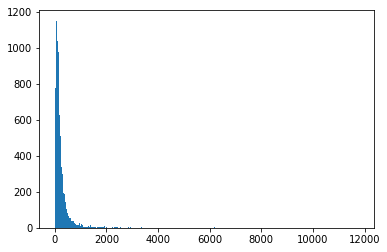

In [17]:
# see the distribution of the document length
doc_len = [len(s.split()) for s in data['document']]
print('min tweet len: ' + str(np.min(doc_len)))
print('max tweet len: ' + str(np.max(doc_len)))
print('avg tweet len: ' + str(np.mean(doc_len)))
plt.hist(doc_len, bins='auto')
plt.show()

In [19]:
# get the documents and labels in numpy array
documents = data['document'].values
y = data['label'].values

In [22]:
documents_train, documents_test, y_train, y_test = train_test_split(documents, y, test_size=0.25, random_state=1000)

In [26]:
MAX_NUM_WORDS = 20000
tokenizer = Tokenizer(num_words = MAX_NUM_WORDS)
tokenizer.fit_on_texts(documents_train)
vocab_size = len(tokenizer.word_index) + 1  # Adding 1 because of reserved 0 index
print('vocab_size: ' + str(vocab_size))

vocab_size: 141598


In [28]:
X_train = tokenizer.texts_to_sequences(documents_train)
X_test = tokenizer.texts_to_sequences(documents_test)

MAX_SEQUENCE_LENGTH = 1000

X_train = pad_sequences(X_train, padding='post', maxlen=MAX_SEQUENCE_LENGTH)
X_test = pad_sequences(X_test, padding='post', maxlen=MAX_SEQUENCE_LENGTH)

In [31]:
embedding_dim = 50
embedding_matrix = create_embedding_matrix('resource/glove.6B.50d.txt', tokenizer.word_index, embedding_dim)

In [32]:
nonzero_elements = np.count_nonzero(np.count_nonzero(embedding_matrix, axis=1))
overlap = nonzero_elements / vocab_size
print('Vocab overlap: ' + str(overlap))

Vocab overlap: 0.4319623158519188


In [6]:
MAX_NUM_WORDS = 20000
MAX_SEQUENCE_LENGTH = 1000

# tokenizing the text and creating vecotr tensor out of that
tokenizer = Tokenizer(num_words=MAX_NUM_WORDS)
tokenizer.fit_on_texts(texts)

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

# vetorizing the text samples into 2D integer tensor 
sequences = tokenizer.texts_to_sequences(texts)
# pad sequences
# MAX_SEQUENCE_LENGTH = max([len(s.split()) for s in texts])
data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)

labels = to_categorical(np.asarray(labels))
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)

Found 174074 unique tokens.
Shape of data tensor: (19997, 1000)
Shape of label tensor: (19997, 20)


In [34]:
# split the data into a training set and a validation set
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]
num_validation_samples = int(VALIDATION_SPLIT * data.shape[0])

x_train = data[:-num_validation_samples]
y_train = labels[:-num_validation_samples]
x_val = data[-num_validation_samples:]
y_val = labels[-num_validation_samples:]

In [3]:
# first, build index mapping words in the embeddings set
# to their embedding vector
print('Indexing word vectors.')

embeddings_index = {}
with open(os.path.join(EMBEDDING_DIR, EMBEDDING_FILE_NAME), encoding="utf8") as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs

Indexing word vectors.


In [4]:
print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [36]:
print('Preparing embedding matrix.')
# prepare embedding matrix
num_words = min(MAX_NUM_WORDS, len(word_index)) + 1
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))
for word, i in word_index.items():
    if i > MAX_NUM_WORDS:
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

Preparing embedding matrix.


In [37]:
# load pre-trained word embeddings into an Embedding layer
# note that we set trainable = False so as to keep the embeddings fixed
embedding_layer = Embedding(num_words,
                            EMBEDDING_DIM,
                            embeddings_initializer=Constant(embedding_matrix),
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=False)

In [40]:
print('Training model.')

# train a 1D convnet with global maxpooling
sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedded_sequences = embedding_layer(sequence_input)
x = Conv1D(128, 5, activation='relu')(embedded_sequences)
x = MaxPooling1D(5)(x)
x = Conv1D(128, 5, activation='relu')(x)
x = MaxPooling1D(5)(x)
x = Conv1D(128, 5, activation='relu')(x)
x = GlobalMaxPooling1D()(x)
x = Dense(128, activation='relu')(x)
# preds = Dense(len(labels_index), activation='softmax')(x)
preds = Dense(20, activation='softmax')(x)

Training model.


In [41]:
model = Model(sequence_input, preds)
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['acc'])

In [42]:
model.fit(x_train, y_train,
          batch_size=128,
          epochs=10,
          validation_data=(x_val, y_val))

Train on 15998 samples, validate on 3999 samples
Epoch 1/10
  128/15998 [..............................] - ETA: 22:15 - loss: 3.1493 - acc: 0.0547

KeyboardInterrupt: 